In [1]:
#general
import pandas as pd

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
)
from scipy.special import softmax
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from skopt import BayesSearchCV
from skopt.space import Integer

import optuna

import numpy as np

import matplotlib.pyplot as plt

#wandb
import wandb
import wandb.sklearn

#### Preprocess data

In [2]:
data = pd.read_csv('data.csv')
data_no_dup = data.drop_duplicates(ignore_index=True)
X, y = data_no_dup.drop(columns='NObeyesdad'), data_no_dup['NObeyesdad']
X['Gender'] = 1 * (X['Gender'] == 'Male')
X['family_history_with_overweight'] = 1 * (X['family_history_with_overweight'] == 'yes')
X['FAVC'] = 1 * (X['FAVC'] == 'yes')
X['SMOKE'] = 1 * (X['SMOKE'] == 'yes')
X['SCC'] = 1 * (X['SCC'] == 'yes')

features_to_one_hot = ['CAEC', 'CALC', 'MTRANS']

ohe = OneHotEncoder(sparse_output=False)
output = ohe.fit_transform(X[features_to_one_hot])
names = ohe.get_feature_names_out()
ohe_df = pd.DataFrame(output, columns=names)
X = X.drop(columns=features_to_one_hot)
X = pd.concat([X, ohe_df], axis=1)

TARGET_NAME_TO_NUMBER = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6, 
}

for i in range(len(y)):
    y[i] = TARGET_NAME_TO_NUMBER[y[i]]

X['TUE_DIV_FAF'] = X['TUE'] / (X['FAF'] + 1e-4)
y = y.to_numpy().astype(int)
X = X.drop(columns=['Weight'])

/var/folders/nk/6l8jhym14zsdp8s7sg3s0lpmp8td26/T/ipykernel_46679/1967962146.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = TARGET_NAME_TO_NUMBER[y[i]]
/var/folders/nk/6l8jhym14zsdp8s7sg3s0lpmp8td26/T/ipykernel_46679/1967962146.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i] = TARGET_NAME_TO_NUMBER[y[i]]
/var/folders/nk/6l8jhym14zsdp8s7sg3s0lpmp8td26/T/ipykernel_46679/1967962146.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

#### Split + normalize

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, shuffle=True, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: orlobster to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(project="orlov-ha2", name='OneVsRestLogReg')
cls = OneVsRestClassifier(LogisticRegression(random_state=42))
cls.fit(X_train, y_train)
y_pred_train = cls.predict(X_train)
y_pred_test = cls.predict(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, cls.predict_proba(X_test), labels=[key for key in TARGET_NAME_TO_NUMBER], log_learning_curve=True, model_name="OneVsRest")
wandb.finish()

wandb: 
wandb: Plotting OneVsRest.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.


accuracy=0.5919540229885057
f1 macro=0.5654247135889988


wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [6]:
wandb.init(project="orlov-ha2", name='OneVsOneLogReg')
cls = OneVsOneClassifier(LogisticRegression(random_state=42))
cls.fit(X_train, y_train)
y_pred_train = cls.predict(X_train)
y_pred_test = cls.predict(X_test)
y_pred_probas = softmax(cls.decision_function(X_test), axis=1)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], log_learning_curve=True, model_name='OneVsOne')
wandb.finish()

wandb: 
wandb: Plotting OneVsOne.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.


accuracy=0.60727969348659
f1 macro=0.5846269669704884


wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [7]:
wandb.init(project="orlov-ha2", name='OneVsOneLinearSVC')
cls = OneVsOneClassifier(LinearSVC(random_state=42))
cls.fit(X_train, y_train)
y_pred_train = cls.predict(X_train)
y_pred_test = cls.predict(X_test)
y_pred_probas = softmax(cls.decision_function(X_test), axis=1)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], log_learning_curve=True)
wandb.finish()

wandb: 
wandb: Plotting Classifier.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.


accuracy=0.6475095785440613
f1 macro=0.6371166484441219


wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [8]:
wandb.init(project="orlov-ha2", name='GradientBoosting')
cls = GradientBoostingClassifier(random_state=42)
cls.fit(X_train, y_train)
y_pred_train = cls.predict(X_train)
y_pred_test = cls.predict(X_test)
y_pred_probas = cls.predict_proba(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], feature_names=list(X.columns), log_learning_curve=True)
wandb.finish()

wandb: 
wandb: Plotting Classifier.


accuracy=0.8275862068965517
f1 macro=0.8247042319253811


wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [9]:
wandb.init(project="orlov-ha2", name='RandomForest')
cls = RandomForestClassifier(random_state=42)
cls.fit(X_train, y_train)
y_pred_train = cls.predict(X_train)
y_pred_test = cls.predict(X_test)
y_pred_probas = cls.predict_proba(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], feature_names=list(X.columns), log_learning_curve=True)
wandb.finish()

wandb: 
wandb: Plotting Classifier.


accuracy=0.8563218390804598
f1 macro=0.8536560979528202


wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [10]:
rf_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': np.arange(50, 1050, 50)
}
rf = RandomForestClassifier(random_state=42)
clf = GridSearchCV(rf, rf_params, scoring='f1_macro')
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])},
             scoring='f1_macro')

In [21]:
clf.best_params_

{'criterion': 'entropy', 'n_estimators': 250}

In [13]:
wandb.init(project='orlov-ha2-rf')

In [14]:
def visualize_grid_search(cv, param1, param2, name1, name2):
    scores_mean = np.array(cv['mean_test_score']).reshape(len(param2), len(param1))
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    for i, value in enumerate(param2):
        ax.plot(param1, scores_mean[i, :], '-o', label=name2 + ': ' + str(value))
    ax.set_xlabel(name1, fontsize=15)
    ax.set_ylabel('f1-macro', fontsize=15)
    ax.legend(loc='best', fontsize=13)
    ax.grid('on')
    wandb.log({'rf': wandb.Image(fig)})
    wandb.finish()

accuracy=0.8524904214559387
f1 macro=0.8493321236416322


wandb: 
wandb: Plotting Classifier.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


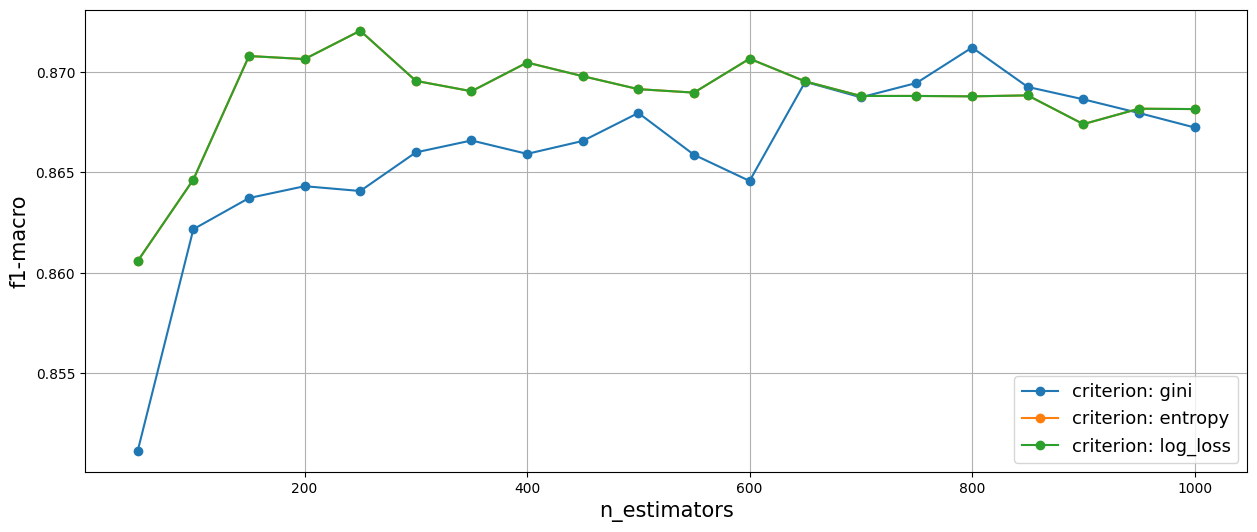

In [15]:
visualize_grid_search(clf.cv_results_, rf_params['n_estimators'], rf_params['criterion'], 'n_estimators', 'criterion')
cls = RandomForestClassifier(n_estimators=250, criterion='entropy', random_state=42)
y_pred_test = cls.fit(X_train, y_train).predict(X_test)
y_pred_probas = cls.predict_proba(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.init(project="orlov-ha2", name='RandomForestGridSearch')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], feature_names=list(X.columns), log_learning_curve=True)
wandb.finish()

In [41]:
boost_params = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': np.arange(50, 550, 100)
}
boost = GradientBoostingClassifier(random_state=42)
clf = GridSearchCV(boost, boost_params, scoring='f1_macro')
clf.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'n_estimators': array([ 50, 150, 250, 350, 450])},
             scoring='f1_macro')

In [42]:
clf.best_estimator_

GradientBoostingClassifier(max_depth=5, n_estimators=450, random_state=42)

In [43]:
wandb.init(project='orlov-ha2-boost')

accuracy=0.8467432950191571
f1 macro=0.8447956900178796


wandb: 
wandb: Plotting Classifier.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


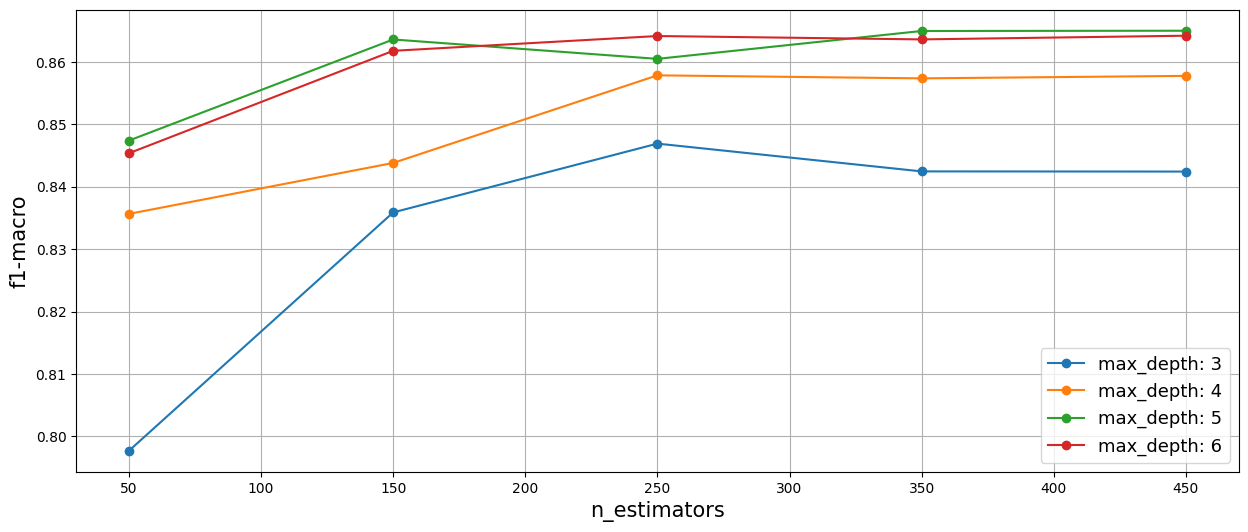

In [44]:
visualize_grid_search(clf.cv_results_, boost_params['n_estimators'], boost_params['max_depth'], 'n_estimators', 'max_depth')

y_pred_test = GradientBoostingClassifier(random_state=42, max_depth=5, n_estimators=450).fit(X_train, y_train).predict(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.init(project="orlov-ha2", name='GradientBoostingGridSearch')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], feature_names=list(X.columns), log_learning_curve=True)
wandb.finish()

In [45]:
rf_params = {
    'n_estimators': Integer(200, 600),
    'max_depth': Integer(7, 30),
}

In [46]:
cls = RandomForestClassifier(random_state=42, criterion='entropy')
bayes_search = BayesSearchCV(cls, rf_params, n_iter=100, cv=5, scoring='f1_macro')
bayes_search.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/pyenv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 200] before, using random point [29, 215]
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pyenv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 201] before, using random point [11, 412]
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pyenv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [21, 200] before, using random point [22, 530]
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pyenv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [28, 200] before, using random point [21, 573]
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pyenv/lib/python3.12/site-package

BayesSearchCV(cv=5,
              estimator=RandomForestClassifier(criterion='entropy',
                                               random_state=42),
              n_iter=100, scoring='f1_macro',
              search_spaces={'max_depth': Integer(low=7, high=30, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=200, high=600, prior='uniform', transform='normalize')})

In [47]:
bayes_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=24, n_estimators=245,
                       random_state=42)

In [48]:
cls = RandomForestClassifier(random_state=42, criterion='entropy', n_estimators=245, max_depth=24)
y_pred_test = cls.fit(X_train, y_train).predict(X_test)
y_pred_probas = cls.predict_proba(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.init(project="orlov-ha2", name='RandomForestBayesSearch')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], feature_names=list(X.columns), log_learning_curve=True)
wandb.finish()

accuracy=0.8524904214559387
f1 macro=0.849354172130594


wandb: 
wandb: Plotting Classifier.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [49]:
from sklearn.model_selection import cross_val_score
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = RandomForestClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro'))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
study.best_trial

[I 2025-03-22 22:21:43,864] A new study created in memory with name: no-name-1ef54c6d-c4cd-4cb7-8d26-6afef4cf7e1b
[I 2025-03-22 22:21:49,525] Trial 0 finished with value: -0.8667803924269484 and parameters: {'n_estimators': 899, 'max_depth': 17, 'criterion': 'entropy'}. Best is trial 0 with value: -0.8667803924269484.
[I 2025-03-22 22:21:51,141] Trial 1 finished with value: -0.8654664248229006 and parameters: {'n_estimators': 301, 'max_depth': 27, 'criterion': 'gini'}. Best is trial 0 with value: -0.8667803924269484.
[I 2025-03-22 22:21:55,644] Trial 2 finished with value: -0.8685710562699873 and parameters: {'n_estimators': 887, 'max_depth': 28, 'criterion': 'gini'}. Best is trial 2 with value: -0.8685710562699873.
[I 2025-03-22 22:22:00,836] Trial 3 finished with value: -0.8661180268888579 and parameters: {'n_estimators': 840, 'max_depth': 17, 'criterion': 'entropy'}. Best is trial 2 with value: -0.8685710562699873.
[I 2025-03-22 22:22:03,123] Trial 4 finished with value: -0.86882524

FrozenTrial(number=47, state=1, values=[-0.8748523975737857], datetime_start=datetime.datetime(2025, 3, 22, 22, 23, 34, 520268), datetime_complete=datetime.datetime(2025, 3, 22, 22, 23, 35, 565233), params={'n_estimators': 169, 'max_depth': 23, 'criterion': 'entropy'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'max_depth': IntDistribution(high=30, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=47, value=None)

In [50]:
study.best_params

{'n_estimators': 169, 'max_depth': 23, 'criterion': 'entropy'}

In [51]:
cls = RandomForestClassifier(random_state=42,
                             criterion=study.best_params['criterion'],
                             n_estimators=study.best_params['n_estimators'],
                             max_depth=study.best_params['max_depth'])
y_pred_test = cls.fit(X_train, y_train).predict(X_test)
y_pred_probas = cls.predict_proba(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.init(project="orlov-ha2", name='RandomForestOptuna')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], feature_names=list(X.columns), log_learning_curve=True)
wandb.finish()

accuracy=0.8505747126436781
f1 macro=0.8474617226100815


wandb: 
wandb: Plotting Classifier.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [52]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 800)
    max_depth = trial.suggest_int('max_depth', 4, 13)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.1, 0.5)

    model = GradientBoostingClassifier(random_state=42, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro'))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2025-03-22 22:25:55,478] A new study created in memory with name: no-name-96e7ec80-51b7-4dbf-935e-79cbebd9a5e6
[I 2025-03-22 22:26:07,152] Trial 0 finished with value: -0.8552031923405261 and parameters: {'n_estimators': 248, 'max_depth': 4, 'learning_rate': 0.4778101437270632}. Best is trial 0 with value: -0.8552031923405261.
[I 2025-03-22 22:26:16,906] Trial 1 finished with value: -0.8262218775850261 and parameters: {'n_estimators': 216, 'max_depth': 11, 'learning_rate': 0.3531684755638665}. Best is trial 0 with value: -0.8552031923405261.
[I 2025-03-22 22:26:30,037] Trial 2 finished with value: -0.7963330907110713 and parameters: {'n_estimators': 340, 'max_depth': 13, 'learning_rate': 0.2652158686392378}. Best is trial 0 with value: -0.8552031923405261.
[I 2025-03-22 22:26:44,600] Trial 3 finished with value: -0.8612162511557082 and parameters: {'n_estimators': 537, 'max_depth': 5, 'learning_rate': 0.31317543356515537}. Best is trial 3 with value: -0.8612162511557082.
[I 2025-03-

In [53]:
study.best_params

{'n_estimators': 689, 'max_depth': 6, 'learning_rate': 0.10808860090795602}

In [54]:
cls = GradientBoostingClassifier(random_state=42,
                                 learning_rate=study.best_params['learning_rate'],
                                 n_estimators=study.best_params['n_estimators'],
                                 max_depth=study.best_params['max_depth'])
y_pred_test = cls.fit(X_train, y_train).predict(X_test)
y_pred_probas = cls.predict_proba(X_test)
print(f'accuracy={accuracy_score(y_test, y_pred_test)}')
print(f'f1 macro={f1_score(y_test, y_pred_test, average='macro')}')
wandb.init(project="orlov-ha2", name='GradientBoostingOptuna')
wandb.sklearn.plot_classifier(cls, X_train, X_test, y_train, y_test, y_pred_test, y_pred_probas, labels=[key for key in TARGET_NAME_TO_NUMBER], feature_names=list(X.columns), log_learning_curve=True)
wandb.finish()

accuracy=0.8467432950191571
f1 macro=0.8438542195946483


wandb: 
wandb: Plotting Classifier.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

data = pd.read_csv('data.csv')
data_no_dup = data.drop_duplicates(ignore_index=True)
X, y = data_no_dup.drop(columns='NObeyesdad'), data_no_dup['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=42, test_size=0.25)

def custom_transform(X):
    X = X.copy()
    X['Gender'] = 1 * (X['Gender'] == 'Male')
    X['family_history_with_overweight'] = 1 * (X['family_history_with_overweight'] == 'yes')
    X['FAVC'] = 1 * (X['FAVC'] == 'yes')
    X['SMOKE'] = 1 * (X['SMOKE'] == 'yes')
    X['SCC'] = 1 * (X['SCC'] == 'yes')
    X['TUE_DIV_FAF'] = X['TUE'] / (X['FAF'] + 1e-4)
    X = X.drop(columns=['Weight'])
    return X

preprocessor = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(sparse_output=False), ['CAEC', 'CALC', 'MTRANS']),
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("custom_transform", FunctionTransformer(custom_transform)),
    ("preprocessor", preprocessor),
    ("scaler", MinMaxScaler()),
    ("classifier", RandomForestClassifier(random_state=42, criterion='entropy', max_depth=24, n_estimators=245))
])

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, "../model.pkl")

['model.pkl']

In [103]:
X_test[:100].to_csv('input.csv', index=False)

In [105]:
joblib.load('demo/model.pkl')

Pipeline(steps=[('custom_transform',
                 FunctionTransformer(func=<function custom_transform at 0x32a5a3100>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['CAEC', 'CALC',
                                                   'MTRANS'])])),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=24,
                                        n_estimators=245, random_state=42))])